# Практическое ДЗ 1. Удаление фона с помощью SVD

Выполнила Горбач Марина, БПМИ 212

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [71]:
%pip install -q moviepy --upgrade
%pip install -q ffmpeg --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [72]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
video.fps

23.976023976023978

In [75]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


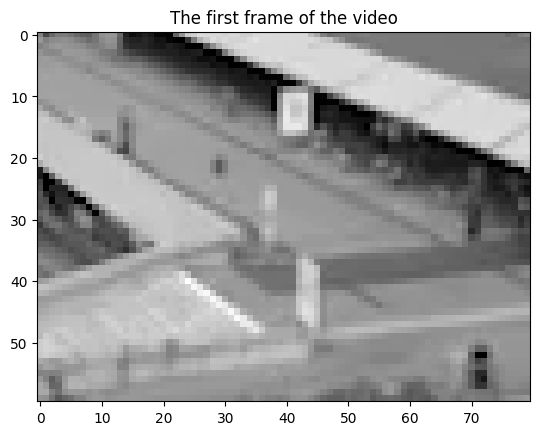

In [76]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

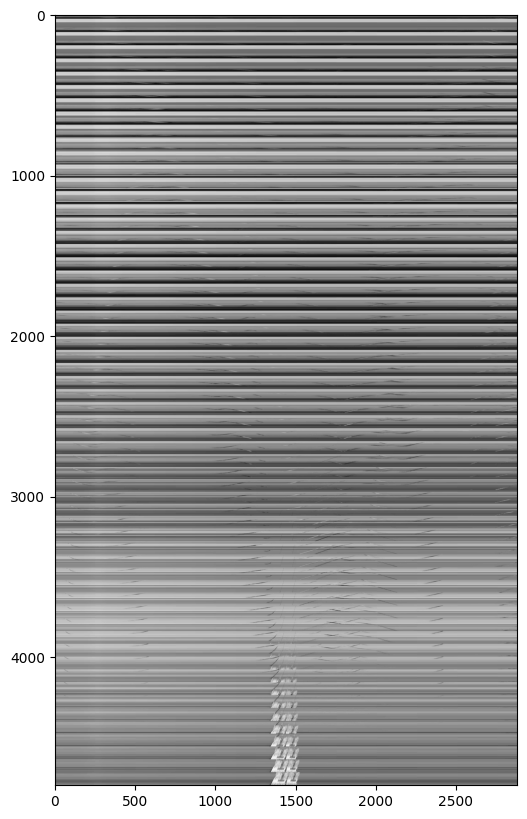

In [77]:
nframes, size_w, size_h = arr.shape
M = np.reshape(arr.transpose(1,2,0), ((size_h * size_w), nframes)) #снача переставили ось времени в конец

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

In [78]:
print(size_w, size_h) # запомним, что size_w это высота

60 80


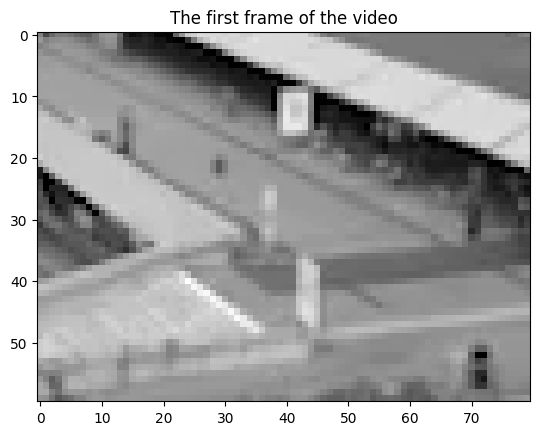

In [79]:
first_frame = M[:,0].reshape((size_w, size_h)) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

Отличается, так как условно говоря, это главное сингулярное значение собирает в себя основную информацию, общую  у всех векторов (далее мы проверим, что с его помощью мы получим фон)

In [80]:
U, Sigm, V = np.linalg.svd(M, full_matrices=False)
print(Sigm)
singular = np.sort(Sigm)[::-1]
print(singular)
singular_dev = singular / singular[0]

[4.86153209e+05 1.46361630e+04 5.23807264e+03 ... 4.85504631e-11
 4.85504631e-11 1.28144474e-11]
[4.86153209e+05 1.46361630e+04 5.23807264e+03 ... 4.85504631e-11
 4.85504631e-11 1.28144474e-11]


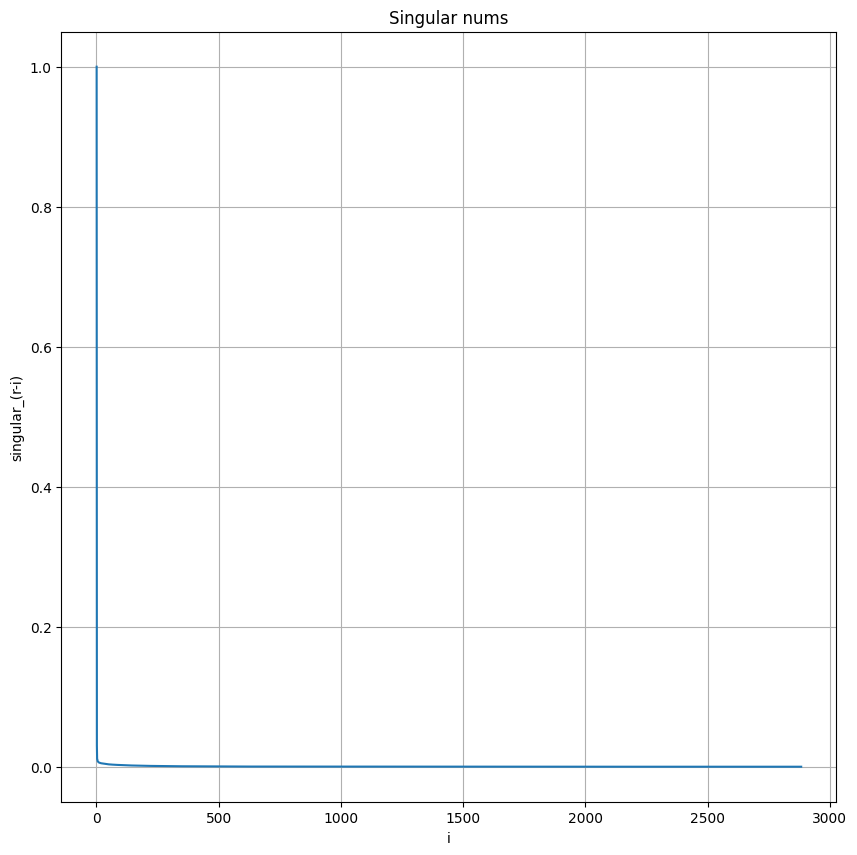

In [81]:
import matplotlib.pyplot as plt
#не логарифмическая шкала, тут действительно не видно, что происходит, кроме резкого роста

plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, singular_dev.size +1), singular_dev)
plt.title('Singular nums')
plt.xlabel('i')
plt.ylabel('singular_(r-i)')
#plt.legend()
plt.grid()
plt.show()

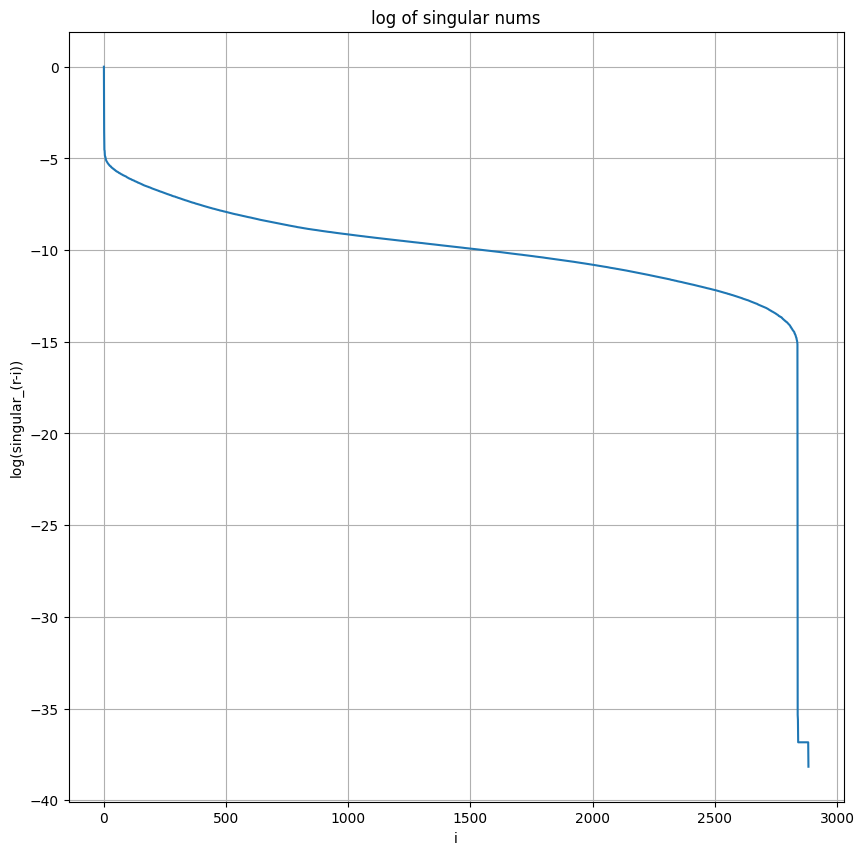

In [82]:
import matplotlib.pyplot as plt
#логарифмическая шкала, тутуже понятно, как именно идёт возрастание

plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, singular_dev.size +1), np.log(singular_dev))
plt.title('log of singular nums')
plt.xlabel('i')
plt.ylabel('log(singular_(r-i))')
#plt.legend()
plt.grid()
plt.show()

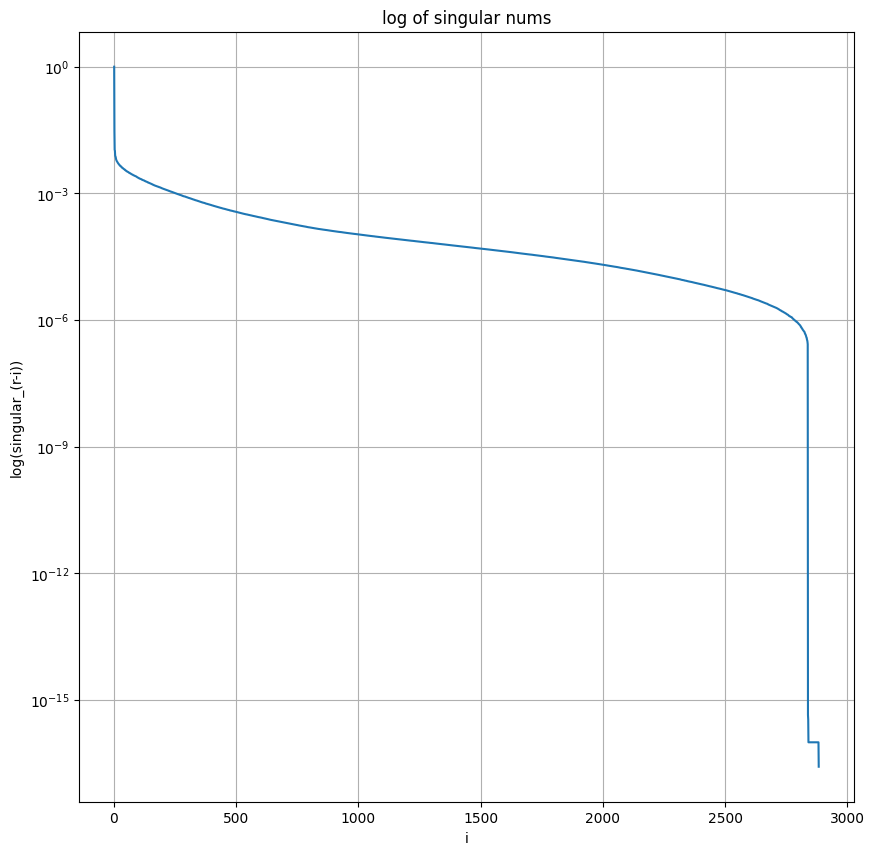

In [83]:
import matplotlib.pyplot as plt
#теперь через функцию из условия

plt.figure(figsize=(10, 10))
plt.semilogy(np.arange(1, singular_dev.size +1), singular_dev)
plt.title('log of singular nums')
plt.xlabel('i')
plt.ylabel('log(singular_(r-i))') #это так как по убыванию сортируем
#plt.legend()
plt.grid()
plt.show()

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $\frac{\|M - M_{r}\|_F}{\|M\|_F}.$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [84]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, Sigm, V = np.linalg.svd(M, full_matrices=False)

    
    Mr = (U[:,:r] @ np.diag(sorted(Sigm, reverse=True)[:r])) @ V[:r]

    norm_up = np.sqrt(np.sum(Sigm[r:] * Sigm[r:]))
    norm_down = np.sqrt(np.sum(Sigm * Sigm))

    return Mr, norm_up/norm_down

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [85]:
M1, norm1 = trunc_svd(M, 1)

print(norm1)

0.055668544769737524


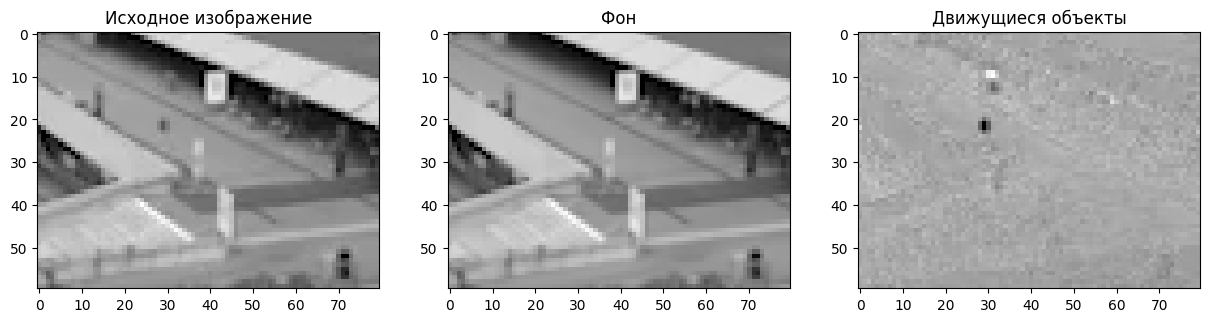

In [86]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(np.reshape(M[:,0], (size_w, size_h)), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(np.reshape(M1[:,0], (size_w, size_h)), cmap='gray') # Фон - наше приближение
axs[1].set_title("Фон")
people = np.reshape(M[:,0], (size_w, size_h)) - np.reshape(M1[:,0], (size_w, size_h))
axs[2].imshow(people, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [87]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


image size: 100 x 178, 
number of frames: 3600


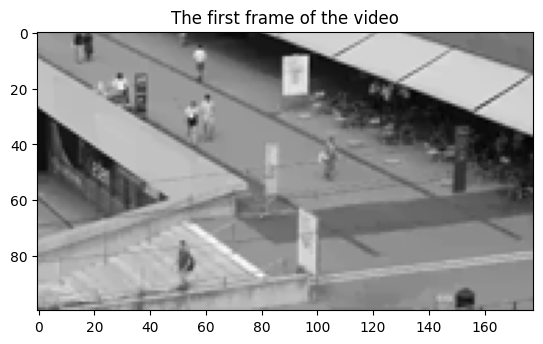

In [88]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = np.reshape(arr.transpose(1,2,0), ((size_h * size_w), nframes))


first_frame = M3[:,0].reshape((size_w, size_h))
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [89]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    n = M.shape[1] # обозначения как в алгоритме из лекции
    OMEGA = np.random.randn(n,r+oversampling)
    Qy, Ry = np.linalg.qr(np.dot(M, OMEGA), mode='reduced')
    W, Sigm, Vt =  np.linalg.svd(np.dot(np.asmatrix(Qy).getH(),M), full_matrices=False)
    Mr = np.dot(np.dot(W[:,:r], np.diag(Sigm[:r])), Vt[:r]) # оставлем лишь первые r значений

    norm_up = np.sqrt(np.sum(Sigm[r:] * Sigm[r:]))
    norm_down = np.sqrt(np.sum(Sigm * Sigm))

    return np.dot(Qy, Mr), norm_up/norm_down

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [90]:
M_rand, norm_rand = rand_svd(M3, 1)

print(norm1)

0.055668544769737524


Text(0.5, 1.0, 'Движущиеся объекты')

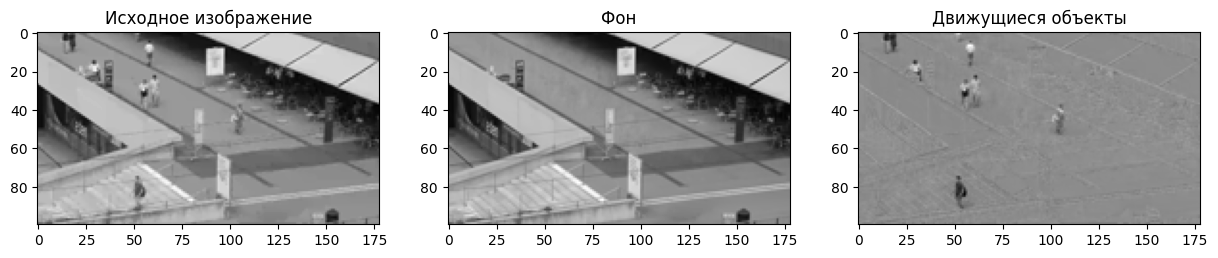

In [91]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(np.reshape(M3[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(np.reshape(M_rand[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(np.reshape(M3[:,0], (size_w, size_h)) - np.reshape(M_rand[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты")

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

In [92]:
r = 2
norms = list()
for p in range(0,30,2):
  Norm = 0
  for _ in range(10):
    M_rand, norm = rand_svd(M3, r, p)
    Norm += norm
  norms.append(Norm / 10)


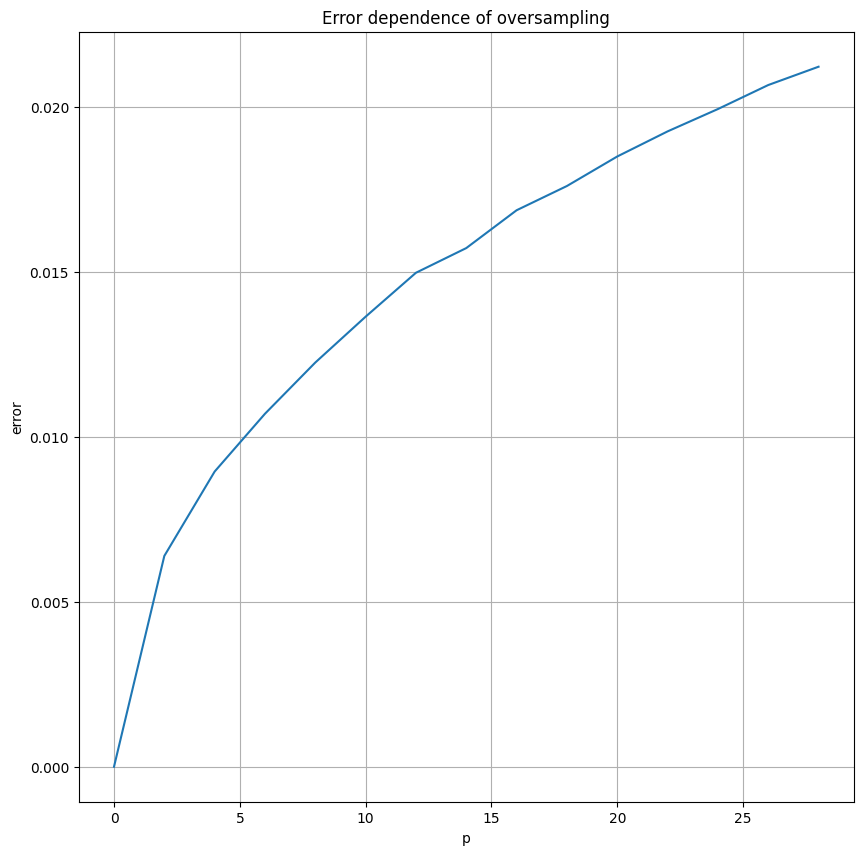

In [93]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.plot(np.arange(0,30,2), np.array(norms))

plt.title('Error dependence of oversampling')
plt.xlabel('p')
plt.ylabel('error')

plt.grid()
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [94]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [95]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [96]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

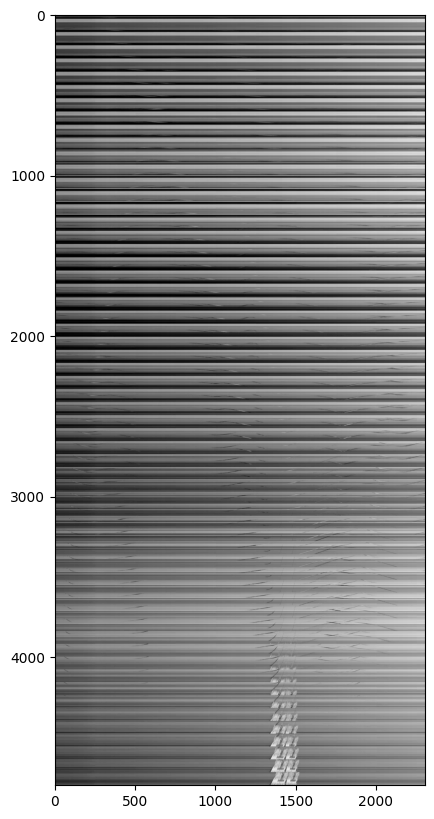

In [97]:
nframes2, size_w, size_h = arr2.shape
M2 = np.reshape(arr2.transpose(1,2,0), ((size_h * size_w), nframes2)) #снача переставили ось времени в конец


plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [98]:
import time 

start = time.time()
M2_svd, _ = trunc_svd(M2, 2)
end = time.time()
print("trunc_svd : ", end - start)

start = time.time()
M2_rand, _ = rand_svd(M2, 2)
end = time.time()
print("trunc_svd : ", end - start)


trunc_svd :  8.5004723072052
trunc_svd :  0.08073067665100098


3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [99]:
p = 10
r = 3
_, norm = trunc_svd(M3, r)
print("library svd on constant lighting :", norm)
_, norm = rand_svd(M3, r, p)
print("rand svd on constant lighting :", norm)
_, norm = trunc_svd(M2, r)
print("library svd on variable lighting :", norm)
_, norm = rand_svd(M2, r, p)
print("rand svd on variable lighting :", norm)



library svd on constant lighting : 0.044672983144155264
rand svd on constant lighting : 0.012504953429953534
library svd on variable lighting : 0.05059151924394069
rand svd on variable lighting : 0.017839638659223264


Выводы: Что ожидаемо, ошибка на видео с изменённым освещением больше, чем на видео с постоянным, ведь мы всё "усредняем" при приближении. 
В то же время для меня было удивительно, что ошибка на рандомизированном алгоритме, меньше, чем на библиотечном (он и работает быстрее, почему тогда не используют его всегда?). Но наверное дело в том, что в нём мы минимизируем вычисления, и тем самым есть меньше возможности для потери точности.

In [100]:
# nframes2, size_w, size_h = arr2.shape
# M2 = np.reshape(arr2.transpose(1,2,0), ((size_h * size_w), nframes2))

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [101]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = np.reshape(M.transpose(1,0), (nframes, size_w, size_h), order='C')
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [102]:
M2_svd, _ = trunc_svd(M2, 2)
print(M2_svd.shape)

(4800, 2306)


In [103]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

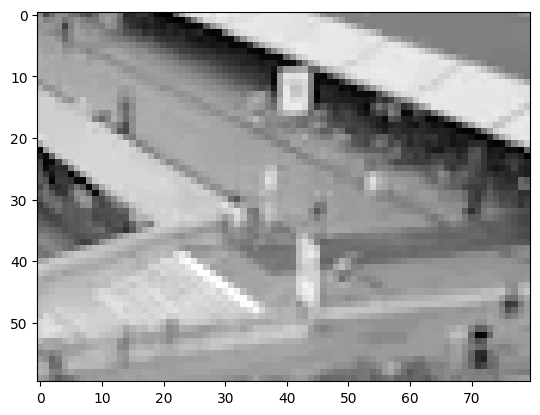

In [104]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray')

In [105]:
# YOUR CODE GOES HERE (duplicate code from trunc_SVD)

# U, Sigm, V = np.linalg.svd(M, full_matrices=False)
# Mr = (U[:,:r] @ np.diag(sorted(Sigm, reverse=True)[:r])) @ V[:r]
r = 2
U, Sigm, V = np.linalg.svd(M2, full_matrices=False)

U_2 = U[:,:r]
S_2 = np.diag(Sigm[:r])
VT_2  = V[:r]

На лекции было утверждение о том, что $Im(M) = Im(U_r)$, поэтому искать проекцию можно для этой матрицы. Помимо того, была выведена формула, что при $M = QR$, $P = QQ^*$.
Заметим, что $QR-\text{разложение}$ для $U_r$ это $U_r I$, значит проекцию можно искать как $Pv = U_r U_r^* v$.

In [106]:
def project_new_frames(U, S, VT, new_frames):
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    if len(new_frames.shape) == 1:
        new_frames = np.array([new_frames]).T

    T = np.dot(np.asmatrix(U).getH(), new_frames) # O(h * w * r * nframes), r = 2, size(T) = (r, nframes), size(U) = (w*h, r)
    
    return np.dot(U, T) # O(r * nframes * h * w)

Text(0.5, 1.0, 'Движущиеся объекты')

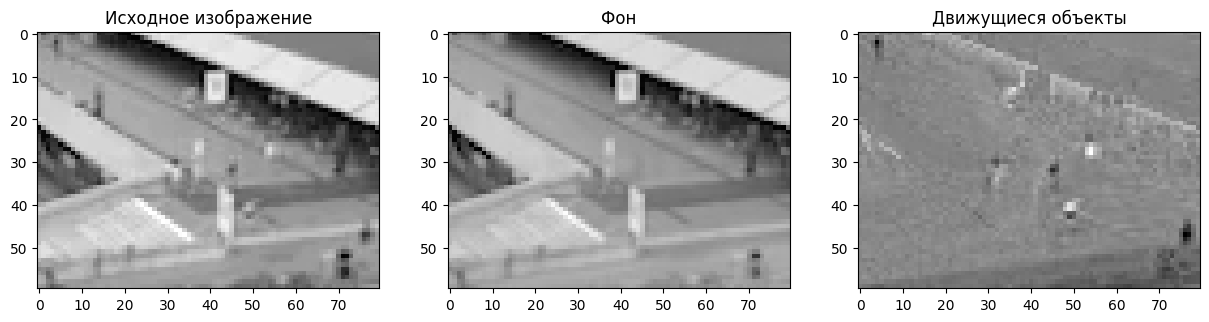

In [107]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(np.reshape(new_frame_proj[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(new_frame.reshape(size_w, size_h) - np.reshape(new_frame_proj[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты")

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


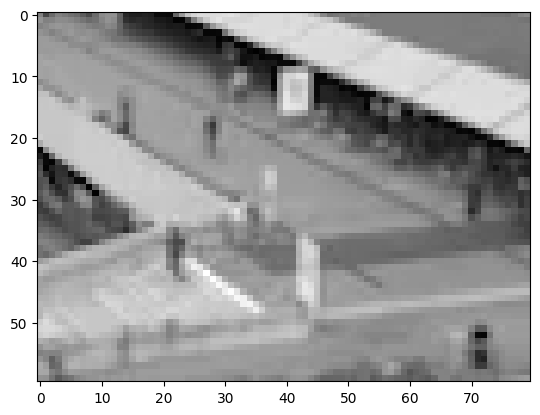

In [108]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = np.reshape(remaining, (remaining_nframes, size_w*size_h)).transpose(1,0)
plt.imshow(M_remaining[:,0].reshape(size_w, size_h), cmap='gray')
M_full = np.concatenate((M2, M_remaining), axis = 1)

In [109]:
print(U_2.shape, S_2.shape, VT_2.shape, M_full.shape)

(4800, 2) (2, 2) (2, 2306) (4800, 2883)


In [110]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)


video2_svd = M_to_video(np.array(M_full - M_proj), 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [111]:
r = 2
oversampling = 10

n = M2.shape[1]
OMEGA = np.random.randn(n,r+oversampling)
Qy, Ry = np.linalg.qr(np.dot(M2, OMEGA), mode='reduced')
W, Sigm, Vt =  np.linalg.svd(np.dot(np.asmatrix(Qy).getH(),M2), full_matrices=False)
# Mr = np.dot(np.dot(W[:,:r], np.diag(Sigm[:r])), Vt[:r]) # оставлем лишь первые r значений
# ans = np.dot(Qy, Mr)


# YOUR CODE GOES HERE (duplicate code from rand_SVD)
U_2_rand = np.dot(Qy, W)[:,:r]
S_2_rand =  np.diag(Sigm[:r])
VT_2_rand = Vt[:r]

In [112]:
print(U_2_rand.shape, S_2_rand.shape, VT_2_rand.shape, M_full.shape)

(4800, 2) (2, 2) (2, 2306) (4800, 2883)


In [113]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(np.array(M_full - M_proj_rand), 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [114]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [115]:
def Frob_norm(A):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    return np.sqrt(np.sum(S * S))
    

In [116]:
error1 = Frob_norm(M_true - M_proj)/Frob_norm(M_true)
print("trunc_svd error : ", error1)

trunc_svd error :  0.020001445065678136


In [117]:
error2 = Frob_norm(M_true - M_proj_rand)/Frob_norm(M_true)
print("rand_svd error : ", error2)

rand_svd error :  0.03555651355740137


**Выводы:**

Видим, что первый алгоритм имеет лучшую точность, но и работает медленнее. А значит, оботись одним рандомизированным алгоритмом не выйдет.

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [118]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2023-02-15 23:29:57--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3,0K) [text/plain]
Saving to: ‘r_pca.py.2’

r_pca.py.2          100%[===================>]   3,03K  --.-KB/s    in 0s      

2023-02-15 23:29:58 (10,4 MB/s) - ‘r_pca.py.2’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [119]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)


iteration: 1, error: 10.068199117425353
iteration: 100, error: 0.7004423976777177
iteration: 200, error: 0.4263207995827979
iteration: 300, error: 0.2861554334234138
iteration: 400, error: 0.19763762992311837
iteration: 500, error: 0.1491945130592448
iteration: 600, error: 0.11977760984790632
iteration: 700, error: 0.1025837967594712
iteration: 800, error: 0.08740324618585692
iteration: 900, error: 0.07772202053923705
iteration: 1000, error: 0.06319242183867149
iteration: 1100, error: 0.057277561609159096
iteration: 1200, error: 0.04361963207374378
iteration: 1300, error: 0.042779182959969755
iteration: 1400, error: 0.02831336361096656
iteration: 1500, error: 0.02821559205561807
iteration: 1546, error: 0.017703452810255604


Text(0.5, 1.0, 'Движущиеся объекты')

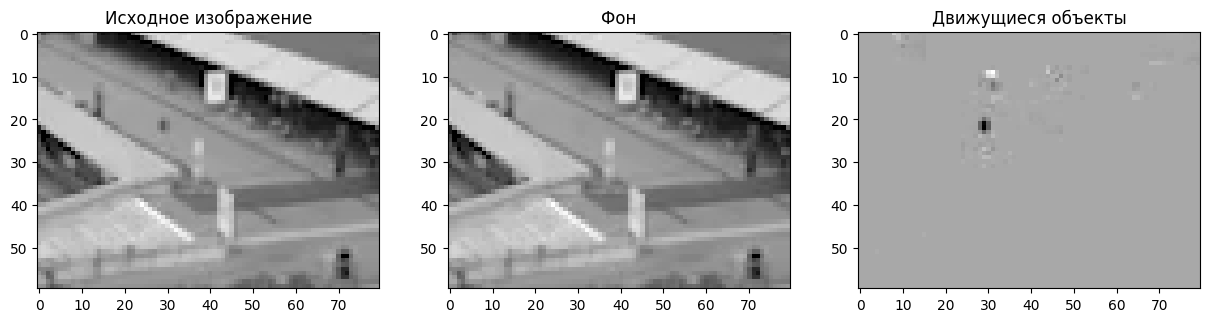

In [120]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M[:,0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:,0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(S[:,0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты")


# axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
# axs[0].set_title("Исходное изображение")
# axs[1].imshow(np.reshape(new_frame_proj[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
# axs[1].set_title("Фон")
# axs[2].imshow(new_frame.reshape(size_w, size_h) - np.reshape(new_frame_proj[:,0], (size_w, size_h)), cmap='gray') # TO BE FILLED
# axs[2].set_title("Движущиеся объекты")

Аналогично можно посмотреть на видео движущихся объектов:

In [121]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [122]:
def Algorithm_4_4(A, r, q):
    n = A.shape[1]
    OMEGA = np.random.randn(n, r)
    Yj = np.dot(A, OMEGA) # Y0
    Qj, _ = np.linalg.qr(Yj, mode='reduced') # Q0
    for j in range(1, q):
        Yj_ = np.dot(np.asmatrix(A).getH(), Qj)
        Qj_, _ = np.linalg.qr(Yj_, mode='reduced')
        Yj = np.dot(A, Qj_)
        Qj, _ = np.linalg.qr(Yj, mode='reduced') # Qj
    return np.dot(Qj,np.dot(np.asmatrix(Qj).getH(), A))

In [123]:
r = 5
norms = list()
Opt, _ = trunc_svd(M,r)
for q in range(1, 10):
    Q = Algorithm_4_4(M, r,q)
    norm = Frob_norm(Q-Opt)
    norms.append(norm)
    print(norm)
    

15402.460235045563
5991.186529889393
5435.104635609901
5100.352231639459
3028.5510792413716
2620.630480186837
2350.456410092537
4205.76888905438
1310.1999280089722


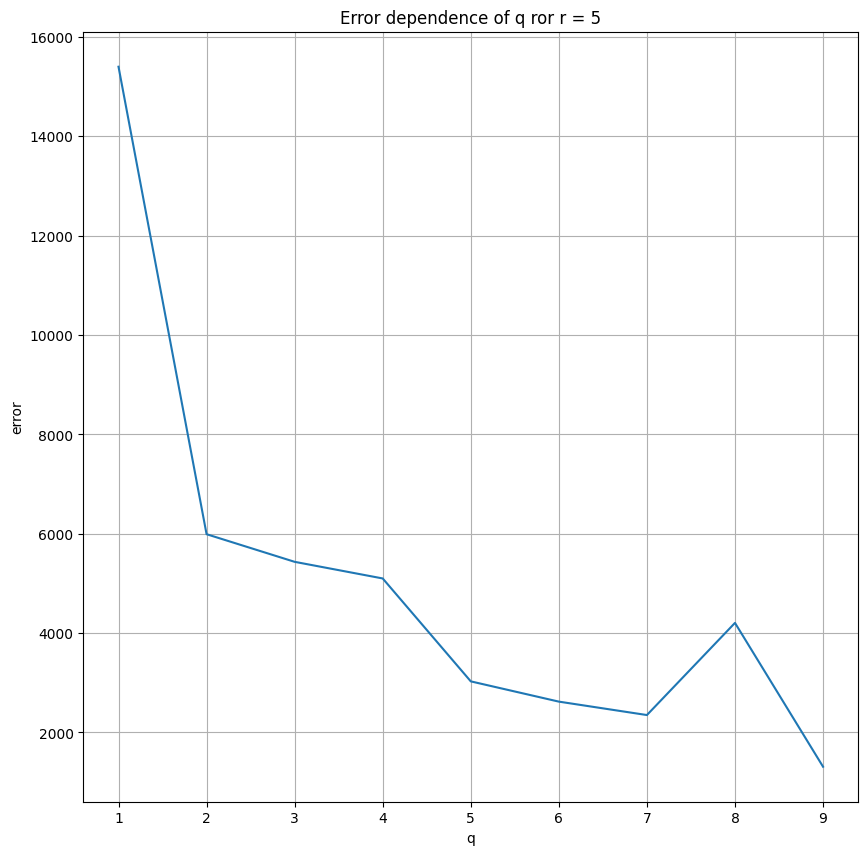

In [124]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.plot(np.arange(1,10), np.array(norms))

plt.title('Error dependence of q ror r = 5')
plt.xlabel('q')
plt.ylabel('error')

plt.grid()
plt.show()

In [125]:
r = 20
norms = list()
Opt, _ = trunc_svd(M,r)
for q in range(1, 10):
    Q = Algorithm_4_4(M, r,q)
    norm = Frob_norm(Q-Opt)
    norms.append(norm)
    print(norm)

13521.311279684804
8373.033425625996
6543.329186710446
5884.957664326682
5610.934664389695
4964.603463565113
4384.615957859257
4464.383906713838
3382.4461498494534


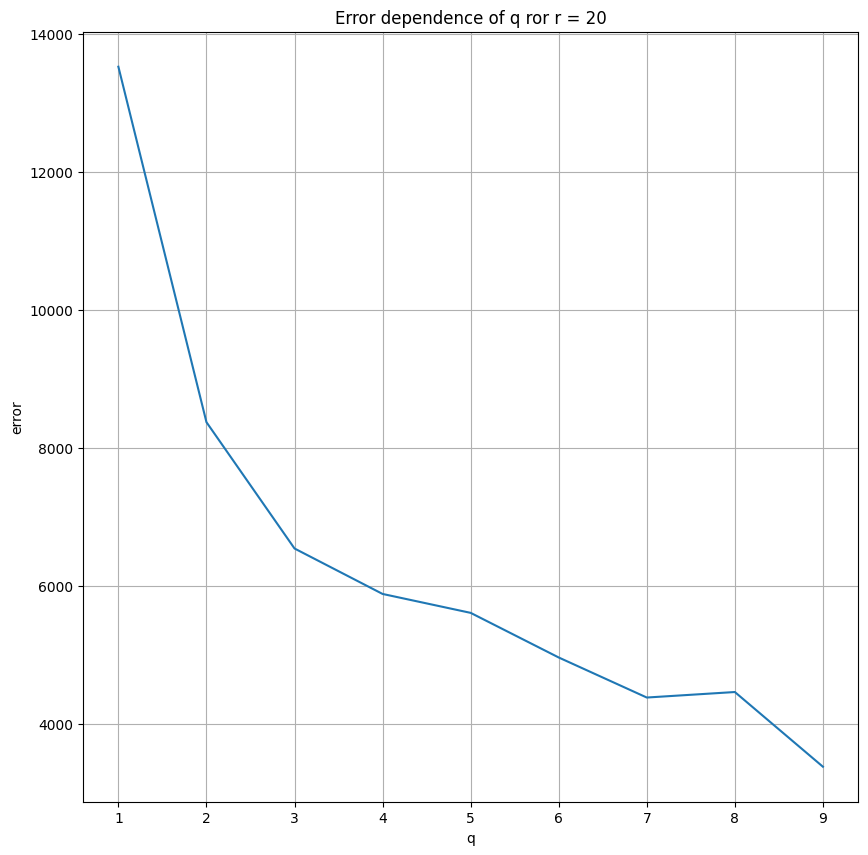

In [126]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.plot(np.arange(1,10), np.array(norms))

plt.title('Error dependence of q ror r = 20')
plt.xlabel('q')
plt.ylabel('error')

plt.grid()
plt.show()

In [127]:
r = 50
norms = list()
Opt, _ = trunc_svd(M,r)
for q in range(1, 10):
    Q = Algorithm_4_4(M, r,q)
    norm = Frob_norm(Q-Opt)
    norms.append(norm)
    print(norm)
    

13706.250142565974
8527.050481777147
6715.7576352928745
5270.4269540469395
4688.732541267114
4605.90110763369
4330.059597515269
3579.157599455062
3575.772765628565


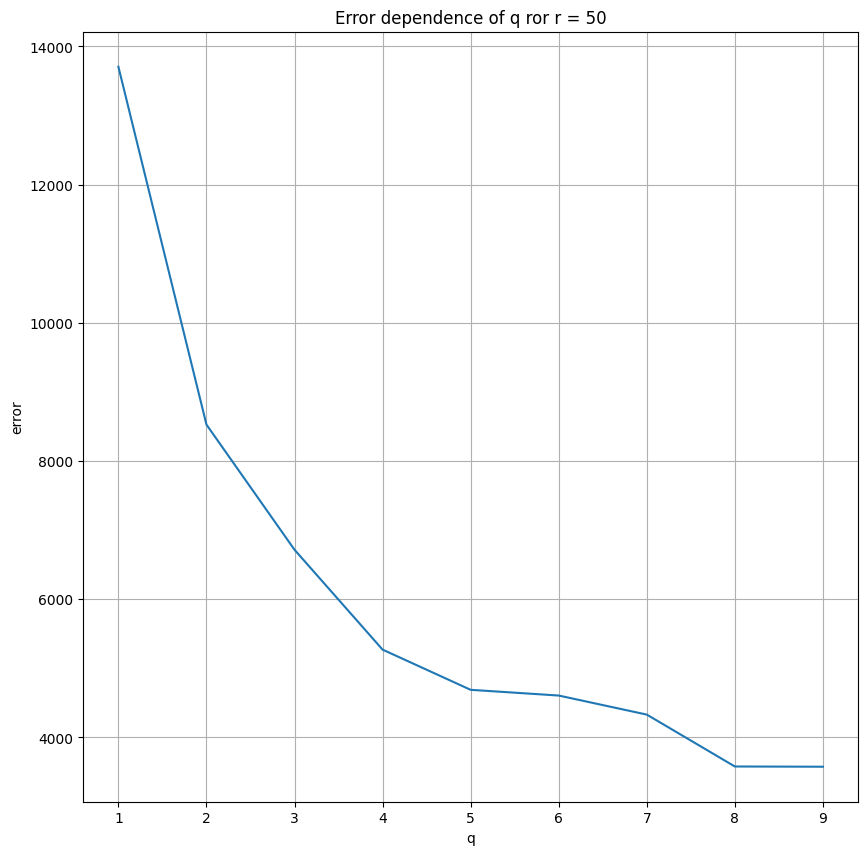

In [128]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.plot(np.arange(1,10), np.array(norms))

plt.title('Error dependence of q ror r = 50')
plt.xlabel('q')
plt.ylabel('error')

plt.grid()
plt.show()

Посмотрим на пример:

In [129]:
r = 5
Opt, _ = trunc_svd(M,r)
q = 5
Q = Algorithm_4_4(M, r,q)
print(Opt)
print("**********")
print(Q)
norm = Frob_norm(Q-Opt)
print(norm)

[[120.02629228 120.02629228 120.02897168 ... 108.54200763 108.52203994
  108.56902691]
 [ 66.85173624  66.85173624  66.85301915 ...  57.18424631  57.16649069
   57.20926241]
 [ 92.95421708  92.95421708  92.95648587 ...  87.07733849  87.05690752
   87.07238918]
 ...
 [127.62744547 127.62744547 127.62915912 ... 120.66500362 120.6780175
  120.73434336]
 [132.28366944 132.28366944 132.28553377 ... 125.5184864  125.49692536
  125.53635883]
 [135.26028528 135.26028528 135.26267056 ... 127.94989518 127.91964121
  127.95690552]]
**********
[[120.06833777 120.06833777 120.07125546 ... 108.74864474 108.739885
  108.78675414]
 [ 66.87562395  66.87562395  66.87742853 ...  57.60593405  57.60767807
   57.65213065]
 [ 92.94004057  92.94004057  92.94252393 ...  87.14128971  87.12487678
   87.14276762]
 ...
 [128.285416   128.285416   128.28507457 ... 120.4660449  120.46499117
  120.4914366 ]
 [132.90192466 132.90192466 132.90280454 ... 125.76323429 125.75094453
  125.77144113]
 [135.75116499 135.75116

In [130]:
print(Q - Opt)
print(np.max(Q-Opt))

[[ 0.04204549  0.04204549  0.04228378 ...  0.2066371   0.21784507
   0.21772723]
 [ 0.02388771  0.02388771  0.02440937 ...  0.42168773  0.44118739
   0.44286823]
 [-0.01417651 -0.01417651 -0.01396193 ...  0.06395122  0.06796926
   0.07037845]
 ...
 [ 0.65797053  0.65797053  0.65591545 ... -0.19895872 -0.21302634
  -0.24290675]
 [ 0.61825522  0.61825522  0.61727077 ...  0.24474789  0.25401918
   0.2350823 ]
 [ 0.49087971  0.49087971  0.49028378 ...  0.27936508  0.29076167
   0.27760729]]
57.065678953622296


1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

4.3 : 

$Y = (AA^∗)^qA\Omega$

 $Y = QR$

4.4 : 

$Y_0 = A\Omega$

$Y_0 = Q_0R_0$

$\hat{Y_1} = A^∗Q_0$

$\hat{Y_1} = \hat{Q_1}\hat{R_1}$

$Y_2 = A\hat{Q_1}$

$\Rightarrow$

$Y_2 \hat{R_1} = A\hat{Q_1}\hat{R_1} = A\hat{Y_1} = AA^∗Q_0 = AA^∗ Q_0$

$\Rightarrow$

$Q_2 R_2 \hat{R_1}R_0= Y_2 \hat{R_1}R_0 = AA^∗ Q_0R_0 = AA^∗Y_0$

Аналогичными рассуждениями по индукции приходим к равенству:


$Q_{2q}R_{2q}\hat{R_{2q-1}}R_{2q-2}\dots\hat{R_1}R_0 = Y_{2q} \hat{R_{2q-1}}R_{2q-2}\dots\hat{R_1}R_0 = (AA^∗)^q Q_0R_0 = (AA^∗)^qY_0=(AA^∗)^q A\Omega$

Тогда RHS = Y из 4.3

Получается: $Q_{2q} = Q$ - доказано (так как произведение всех этих верхнетреугольных матриц - тоже верхнетреугольная)